In [1]:
import pandas as pd
import numpy as np
import PIL
import os
import json
import cv2
import os
import numpy as np
from collections import Counter
import shutil
import sklearn
import sklearn.metrics as metrics
import pytesseract
from matplotlib.pyplot import imshow
%matplotlib inline

# Simple CNN model for CIFAR-10
import keras
from keras.layers import Dense,Dropout,Flatten, Activation,Conv1D,MaxPooling1D,LSTM,Embedding,Input,Conv2D
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import Model
from keras.preprocessing import sequence
from keras import backend as K

import keras_metrics
K.common.set_image_dim_ordering('th')
import tensorflow as tf
# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from matplotlib import pyplot
#import scipy.misc.toimage 
from PIL import Image


def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

# load data
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()
from IPython.display import Image

Using TensorFlow backend.


Stages of Optical Character Recognition


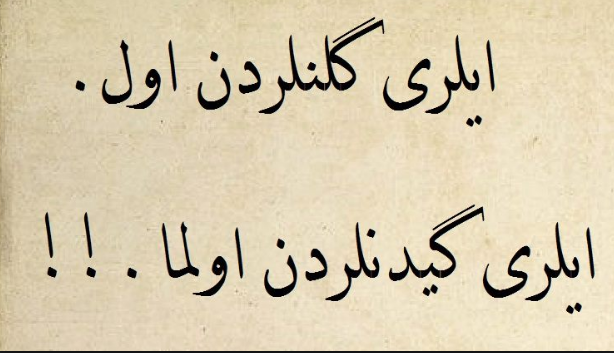

In [2]:
print("Stages of Optical Character Recognition")
Image(filename='/home/furkan/Desktop/Ottoman Research/osmanlica.PNG')

In [3]:
file =  r'/home/furkan/Desktop/Ottoman Research/osmanlica.PNG'
#file = r'output2/sample.jpg'
image = PIL.Image.open(file)
text = pytesseract.image_to_string(image,'ara')
print(text)

م
الرى كلنلردن اول.
المرئ كبدتردن اونا 7


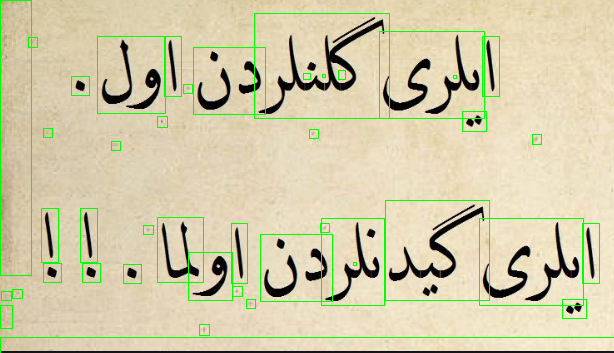

In [4]:
file =  r'/home/furkan/Desktop/Ottoman Research/osmanlica.PNG'

im1 = cv2.imread(file, 0)
im = cv2.imread(file)

ret,thresh1 = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)
kernel = np.ones((5,5),np.uint8)
dilated = cv2.dilate(thresh1,kernel,iterations = 2)
contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cordinates = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cordinates.append((x,y,w,h))
    #bound the images
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)

#cv2.namedWindow('osmanlica21', cv2.WINDOW_NORMAL)
cv2.imwrite('/home/furkan/Desktop/Models/osmanlica21.png',im)

from IPython.display import Image
Image(filename='/home/furkan/Desktop/Models/osmanlica21.png',width=800,height=400)

In [5]:
import pickle

In [6]:
# open a file, where you ant to store the data
file = open('/home/furkan/Desktop/Models/cord/Cordinates', 'wb')
# dump information to that file
pickle.dump(cordinates, file)
# close the file
file.close()

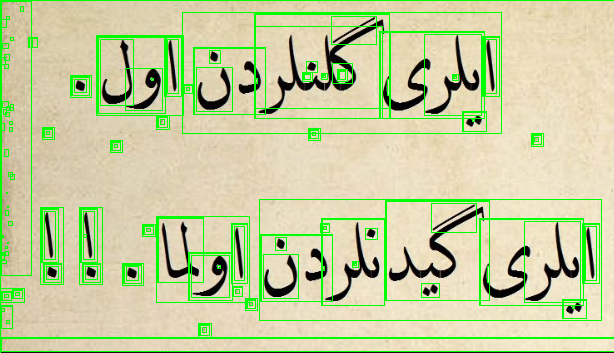

In [7]:
im1 = cv2.imread('/home/furkan/Desktop/Models/osmanlica21.png',0)
im = cv2.imread('/home/furkan/Desktop/Models/osmanlica21.png')

ret,thresh1 = cv2.threshold(im1,180,278,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)
i=0
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w>100 and h>100:
        #save individual images
        cv2.imwrite(str(i)+".png",thresh1[y:y+h,x:x+w])
        i=i+1
#cv2.namedWindow('osmanlica21', cv2.WINDOW_NORMAL)
cv2.imwrite('/home/furkan/Desktop/Models/osmanlica21.png',im)
from IPython.display import Image
Image(filename='/home/furkan/Desktop/Models/osmanlica21.png',width=800,height=400)



In [8]:
len(contours)

157

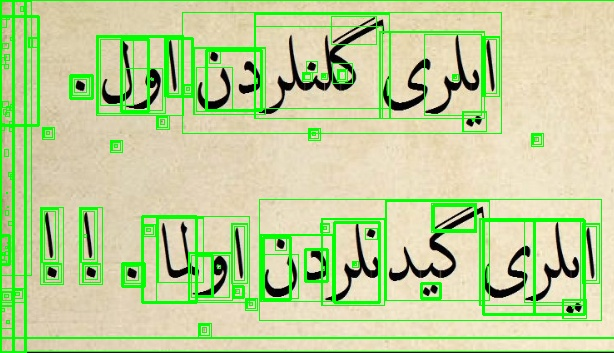

In [9]:


# read the image and get the dimensions
img = cv2.imread('/home/furkan/Desktop/Models/osmanlica21.png')
h, w,_= img.shape # assumes color image

# run tesseract, returning the bounding boxes
boxes = pytesseract.image_to_boxes(img).split('\n') # also include any config options you use
# Box = list(map(lambda box:(box[:1],list(map(int,box[2:][:-2].split(' ')))),boxes))

# draw the bounding boxes on the image
for b in boxes:
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
# show annotated image and wait for keypress
# cv2.imshow(files[0], img)

cv2.imwrite('exboxe.jpg',img)

from IPython.display import Image
Image(filename='exboxe.jpg',width=800,height=400)



In [10]:
len(boxes)

78

In [11]:
count = 0
for component in zip(contours, hierarchy[0]):
    currentContour = component[0]
    currentHierarchy = component[1]
    x,y,w,h = cv2.boundingRect(currentContour)
    if currentHierarchy[3] <= 0:
        # these are the outermost parent components
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,128),1)
        count = count + 1
        letter = im[y:y+h,x:x+w]
        # Create a folder of output to store each cropped letter image
        cv2.imwrite('output2/letters/l-{}.png'.format(count),letter)
#     elif currentHierarchy[2] < 0:
#         # these are the innermost child components
#         cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)

# Finally show the image
cv2.imwrite('img.png',im)
print(count)

16


In [12]:
def Preprocess_Images(letters_path):
    '''
    Function to read all labelled images in the folder, resizing all images to one specific size of pixels and
    to add in array of information in representing training data for ConvNet model.
    
    Parameters
    ----------
    letters_path     -  folder in which all cropped contour images labelled with associated names.
    
    Returns
    -------
    data         -  Numpy array all images information
    data_y       -  enoded integer information of all labels of training data
    encod_y      -  Encoding associated with the labels 
    
    '''
    
    # reading labels of all image data
    letters = [j[:-4][-1] for j in os.listdir(letters_path)]
    letter_dict = dict([(k,[j for j in os.listdir(letters_path) if j[:-4][-1] ==k])  for k in Counter(letters).keys()])

    encod_y = dict(zip(np.unique(letters),np.arange(len(np.unique(letters)))))

    data = []
    data_y = []
    for key in letter_dict.keys():
        for let in letter_dict[key]:
            im = PIL.Image.open(os.path.join(letters_path,let))
            data.append(np.array(im.resize([32,32],PIL.Image.ANTIALIAS)))
            data_y.append(encod_y[key])

    #Image.fromarray(da1[345])
    data = np.array(data).reshape((len(data),32,32,3))
    data_y = np.array(data_y).reshape(len(data_y),1)
    
    return data,data_y,encod_y

In [35]:
data, data_y, encod_y = Preprocess_Images(r'/home/furkan/Desktop/latin/')

In [36]:
shfl = np.arange(len(data))
np.random.shuffle(shfl)

X_train,y_train = data[shfl[:int(len(data)*0.8)]],data_y[shfl[:int(len(data)*0.8)]]
X_test,y_test = data[shfl[int(len(data)*0.8):]],data_y[shfl[int(len(data)*0.8):]]

In [37]:
shfl = np.arange(len(data))
shfl

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

p


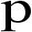

In [46]:
n = 15
for i in encod_y.keys():
    if encod_y[i]==data_y[n][0]:
        print(i)
PIL.Image.fromarray(data[n])

In [47]:
data.shape

(35, 32, 32, 3)

g


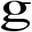

In [48]:
for i in encod_y.keys():
    if encod_y[i]==y_train[n][0]:
        print(i)
PIL.Image.fromarray(X_train[n])

In [49]:
y_train_unq, y_train_ids = np.unique(y_train, return_inverse=True)
y_test_unq,y_test_ids  = np.unique(y_test, return_inverse=True)

y_train = keras.utils.np_utils.to_categorical(y_train_ids,len(y_train_unq))
y_test = keras.utils.np_utils.to_categorical(y_test_ids,len(y_test_unq))

In [50]:
from keras.layers import Flatten

def ConvNet_Model(X_train,y_train):
    '''
    Function to build a Convolution neural Network with the use of keras neural network library
    Neural Network is incorporated with the Convolution filters layers followed by Pooling layer and 
    output layer of softmax label prediction.
    
    '''
    X_input = Input(X_train.shape)
    X = Conv2D(filters=32, padding='same', activation='relu', kernel_size= (3,3), kernel_constraint=maxnorm(3))(X_input)
    X = Dropout(0.2)(X)
    X = Conv2D(filters=32, padding='same', activation='relu',kernel_size= (3,3), kernel_constraint=maxnorm(3))(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = keras.layers.Flatten()(X)
 
    X = Dense(512,activation='relu')(X)
    X = Dropout(0.5)(X)
    
    #flattened = Flatten()(X)
    
    X=Dense(39,activation='softmax')(X)
    model=Model(inputs=X_input,outputs=X,name='Convolve')
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[auc_pr])
    return model

In [51]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

/home/furkan/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (28, 32, 32, 3) (32 channels).
  ' channels).')


In [52]:
model = ConvNet_Model(X_train[1],y_train)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[auc_pr])

In [53]:
model.summary()

Model: "Convolve"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 3)         9248      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 3)         9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 16, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262

In [54]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),validation_data=(X_test,y_test),
                    steps_per_epoch=len(X_train) / 32, epochs=50)

/home/furkan/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (28, 32, 32, 3) (32 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


ValueError: Error when checking target: expected dense_6 to have shape (35,) but got array with shape (7,)

In [ ]:
X_train.shape

In [30]:
len(X_train)

28

In [ ]:
X_input = Input(X_train.shape)
print(X_input)